# Detecção de DeepFake de áudio a partir de imagens

Instala todas as dependências necessárias

In [63]:
# importa as bibliotecas

import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
from PIL import ImageFont
import matplotlib.pyplot as plt
import visualkeras as vk

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.losses import CategoricalCrossentropy
from keras.losses import categorical_crossentropy
from keras import regularizers
from keras import initializers
import time
from keras.preprocessing.image import ImageDataGenerator  # , load_img
from keras.utils import to_categorical, plot_model
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

Num GPUs Available:  2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [27]:
#TF_GPU_ALLOCATOR=cuda_malloc_async
# Começa a contar o tempo de processamento
start_time = time.time()

# Setando o endereço dos arquivos

os.getcwd()


Path = '/mnt/f/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Datasets/'
PathASV = 'ASVspoof/PA/PA/'
PathWave = 'WaveFake/newData/'
PathFoR = 'FoR/for-2sec-mel/'

### Funções Aplicadas

In [28]:
def createList(paths,classe):
    auxLista = []
    auxDir = []
    for i in paths:
        lista = os.listdir(i)
        try:
            lista.remove("desktop.ini")
        except:
            print("não existe desktop.ini")
        
        for j in lista:
            auxLista.append(classe)
            auxDir.append(i + j)
            
    return pd.DataFrame({'filename': auxDir, 'category': auxLista})

In [29]:
def datagenCreate(data, Path, IMAGE_SIZE, batch_size,shuffle):
    test_datagen = ImageDataGenerator(
        rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        data,
        Path,
        x_col='filename',
        y_col='category',
        seed=30,
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )
    return test_generator

In [30]:
def prediction(data, total_test, batch_size, model):
    predict = model.predict(
        data,
        steps=np.ceil(total_test/batch_size),
        verbose=1)
    
    return predict

In [31]:
def plotConfusionMatrix(predicted,original):
    conf = confusion_matrix(y_pred=predicted,y_true=original)
    disp = ConfusionMatrixDisplay(conf)
    disp.plot()
    plt.show()

In [32]:
def results(dataModel, testModel, predicted, original):
    
    pred = []
    orig = []
    for cat in predicted:
        if cat == 'Fake':
            pred.append(0)
        else:
            pred.append(1)
            
    for cat in original:
        if cat == 'Fake':
            orig.append(0)
        else:
            orig.append(1)
    
    print("\nTraining Dataset: " + dataModel + "  Test Basis: " + testModel)
    print("Accuracy: " + str(accuracy_score(orig, pred)))
    print("F1-score: " + str(f1_score(orig, pred)))
    print("Precision: " + str(precision_score(orig, pred)))
    print("Recall: " + str(recall_score(orig, pred)))

### Criação do Banco de Dados a Partir das Imagens

In [33]:
os.chdir(Path)

real = createList([PathFoR + "testing/real/",
                   PathFoR + "training/real/",
                   PathFoR + "validation/real/"],
                  1)
fake = createList([PathFoR + "testing/fake/",
                   PathFoR + "training/fake/",
                   PathFoR + "validation/fake/"],
                  0)

FoRData = [real, fake]
FoRData = pd.concat(FoRData).replace({1: 'Real', 0: 'Fake'})

trFoR, tsFoR = train_test_split(FoRData, test_size=0.3, random_state=42)
tsFoR, vlFoR = train_test_split(tsFoR, test_size= 0.5, random_state=42)

In [34]:
os.chdir(Path)

real = createList([PathWave + "realImgMEL/"],1)
fake = createList([PathWave + "fakeImgMEL/"],0)
fake = fake.sample(frac=1).reset_index(drop=True)

fake1 = fake[:len(real)]
#fake2 = fake[len(real):].replace({0: 'Fake'})

WaveData = [real, fake1]
WaveData = pd.concat(WaveData).replace({1: 'Real', 0: 'Fake'})

trWave, tsWave = train_test_split(WaveData, test_size=0.3, random_state=42)
tsWave, vlWave = train_test_split(tsWave, test_size= 0.5, random_state=42)
#tsWave = pd.concat([tsWave, fake2])

In [35]:
os.chdir(Path)

real = createList([PathASV + "realImgMEL/"],1)
fake = createList([PathASV + "fakeImgMEL/"],0)
fake = fake.sample(frac=1).reset_index(drop=True)

fake1 = fake[:len(real)]
#fake2 = fake[len(real):].replace({0: 'Fake'})

ASVData = [real, fake1]
ASVData = pd.concat(ASVData).replace({1: 'Real', 0: 'Fake'})

trASV, tsASV = train_test_split(ASVData, test_size=0.3, random_state=42)
tsASV, vlASV = train_test_split(tsASV, test_size= 0.5, random_state=42)
#tsWave = pd.concat([tsWave, fake2])

não existe desktop.ini
não existe desktop.ini


In [36]:
tr = pd.concat([trFoR, trASV, trWave])
vl = pd.concat([vlFoR, vlASV, vlWave])

### Modelagem da CNN

In [37]:
os.chdir(Path)

In [38]:
# Define Constants
FAST_RUN = True
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [39]:
# Gerando o modelo
model = Sequential()

model.add(Conv2D(8, (5, 5), activation='relu', input_shape=(
    IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

'''
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
'''
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(
    5000,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    activation='relu',
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(
    2,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    activation='softmax',
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))

2024-02-01 11:21:21.575353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 11:21:21.576359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 11:21:21.577155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 11:21:21.577892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 11:21:21.578672: I tensorflow/compile

In [40]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="adam"
)
'''
opt = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.2,
    nesterov=False,
    name="SGD"
)
'''

model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 batch_normalization (Batch  (None, 252, 252, 8)       32        
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 126, 126, 8)       0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 126, 126, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       72        
                                                                 
 batch_normalization_1 (Bat  (None, 126, 126, 8)       3

 batch_normalization_6 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 average_pooling2d_3 (Avera  (None, 14, 14, 64)        0         
 gePooling2D)                                                    
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        4160      
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 batch_nor

In [41]:
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after one steps
fname = "weights-best.hdf5"
#fname = "weights-{epoch:02d}-{val_categorical_accuracy:.4f}.hdf5"
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after one steps
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='categorical_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    fname,
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Saved callbacks parameters
#callbacks = [earlystop, learning_rate_reduction,model_checkpoint]
callbacks = [learning_rate_reduction,model_checkpoint]

In [42]:
total_train = tr.shape[0]
total_validate = vl.shape[0]

total_testFoR = tsFoR.shape[0]
total_testASV = tsASV.shape[0]
total_testWave = tsWave.shape[0]
batch_size = 32

In [43]:
os.chdir(Path)
trn = tr.sample(frac=1, random_state = 42)
add = "training"

train_generator = datagenCreate(trn, Path, IMAGE_SIZE, batch_size, True)

Found 106144 validated image filenames belonging to 2 classes.


In [44]:
val = vl.sample(frac=1, random_state = 42)
add = "validation"

validation_generator = datagenCreate(val, Path, IMAGE_SIZE, batch_size, False)

Found 22747 validated image filenames belonging to 2 classes.


In [45]:
model.save('model-Mel.h5',save_format='h5')

/home/lucas/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
#PathImg = 'D:/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Imagens'
PathImg = '/mnt/d/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Imagens'

In [28]:
# If something go wrong, it will start from best weights
'''
model.load_weights(fname)
model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)
'''

In [47]:
#tf.tf_reset_default_graph()

# Treinamento e validação da rede
Epochs = 20 if FAST_RUN else 100
history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=validation_generator,#train_generator,
    validation_steps=total_validate//batch_size,#total_train//batch_size,
    steps_per_epoch=total_train//batch_size,#100,
    # [Originally steps per epoch should be total_train//batch_size but for now lets try with 50]
    callbacks=callbacks
)

Epoch 1/20


2024-02-01 11:35:50.211350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-01 11:35:51.420661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-01 11:35:52.511121: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 11:35:53.067936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-01 11:35:53.293088: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6580047d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 11:35:53.293238: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor devi

3317/3317 [==============================] - ETA: 0s - loss: 2.4863 - categorical_accuracy: 0.8398
Epoch 1: val_categorical_accuracy improved from -inf to 0.60374, saving model to weights-best.hdf5
3317/3317 [==============================] - 2638s 792ms/step - loss: 2.4863 - categorical_accuracy: 0.8398 - val_loss: 4.3709 - val_categorical_accuracy: 0.6037 - lr: 0.0010
Epoch 2/20
3317/3317 [==============================] - ETA: 0s - loss: 1.5314 - categorical_accuracy: 0.9202
Epoch 2: val_categorical_accuracy improved from 0.60374 to 0.92249, saving model to weights-best.hdf5
3317/3317 [==============================] - 2351s 709ms/step - loss: 1.5314 - categorical_accuracy: 0.9202 - val_loss: 1.3073 - val_categorical_accuracy: 0.9225 - lr: 0.0010
Epoch 3/20
3317/3317 [==============================] - ETA: 0s - loss: 1.2479 - categorical_accuracy: 0.9336
Epoch 3: val_categorical_accuracy improved from 0.92249 to 0.95616, saving model to weights-best.hdf5
3317/3317 [=================

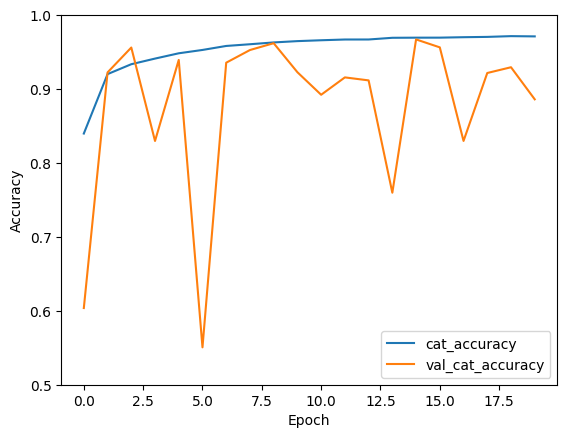

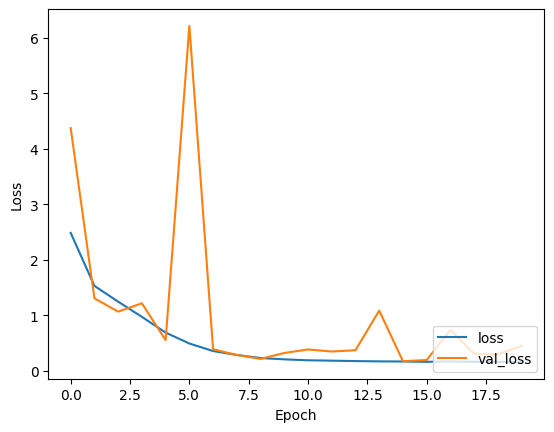

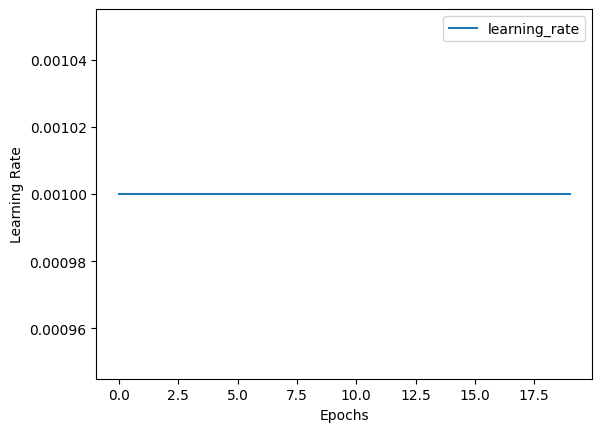

In [48]:
# ----------------------------------- Teste da rede -----------------------------#

plt.figure()
plt.plot(history.history['categorical_accuracy'], label='cat_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_cat_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['lr'], label='learning_rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

Carregar o modelo com melhor resultado de acurácia

In [49]:
model.load_weights(fname)
model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [55]:
os.chdir(Path)
testFoR = tsFoR.sample(frac = 1, random_state = 42)

testFoR_generator = datagenCreate(testFoR, Path, IMAGE_SIZE, batch_size, False)

Found 2680 validated image filenames belonging to 2 classes.


In [56]:
testWave = tsWave.sample(frac = 1, random_state = 42)

testWave_generator = datagenCreate(testWave, Path, IMAGE_SIZE, batch_size, False)

Found 13023 validated image filenames belonging to 2 classes.


In [57]:

testASV = tsASV.sample(frac = 1, random_state = 42)

testASV_generator = datagenCreate(testASV, Path, IMAGE_SIZE, batch_size, False)

Found 7042 validated image filenames belonging to 2 classes.


In [58]:
label_map = dict((v, k) for k, v in train_generator.class_indices.items())

In [59]:
predict = prediction(testFoR_generator,
                     len(tsFoR["category"]),
                     batch_size,
                     model)

testFoR['Pred_category'] = np.argmax(predict, axis=1)
testFoR['Pred_category'] = testFoR['Pred_category'].replace(label_map)

84/84 [==============================] - 57s 673ms/step


In [60]:
predict = prediction(testASV_generator,
                     len(tsASV["category"]),
                     batch_size,
                     model)

testASV['Pred_category'] = np.argmax(predict, axis=1)
testASV['Pred_category'] = testASV['Pred_category'].replace(label_map)

221/221 [==============================] - 146s 659ms/step


In [61]:
predict = prediction(testWave_generator,
                     len(tsWave["category"]),
                     batch_size,
                     model)

testWave['Pred_category'] = np.argmax(predict, axis=1)
testWave['Pred_category'] = testWave['Pred_category'].replace(label_map)

407/407 [==============================] - 328s 805ms/step


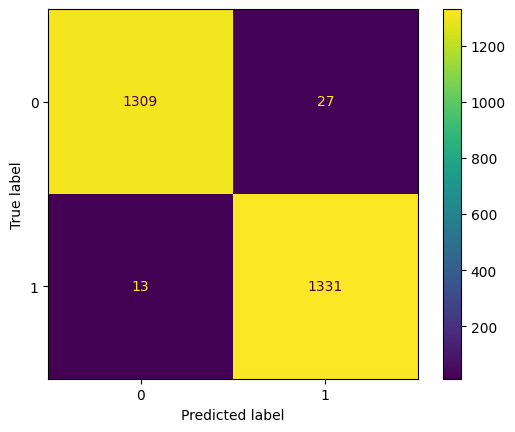


Training Dataset: Full  Test Basis: FoR
Accuracy: 0.9850746268656716
F1-score: 0.9851961509992597
Precision: 0.9801178203240059
Recall: 0.9903273809523809


In [64]:
plotConfusionMatrix(testFoR['Pred_category'], testFoR['category'])
results("Full", "FoR",testFoR["Pred_category"], testFoR["category"])

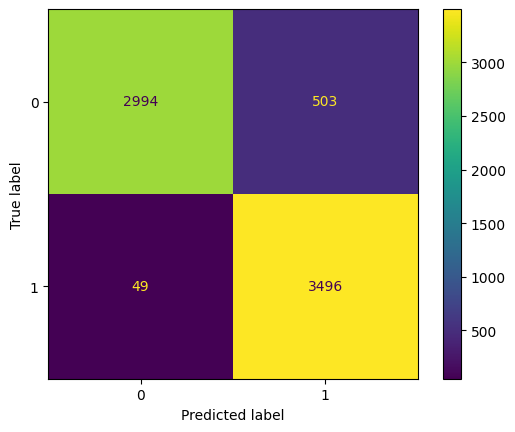


Training Dataset: Full  Test Basis: ASV
Accuracy: 0.9216131780744107
F1-score: 0.9268292682926829
Precision: 0.8742185546386597
Recall: 0.9861777150916784


In [65]:
plotConfusionMatrix(testASV['Pred_category'], testASV['category'])
results("Full", "ASV",testASV["Pred_category"], testASV["category"])

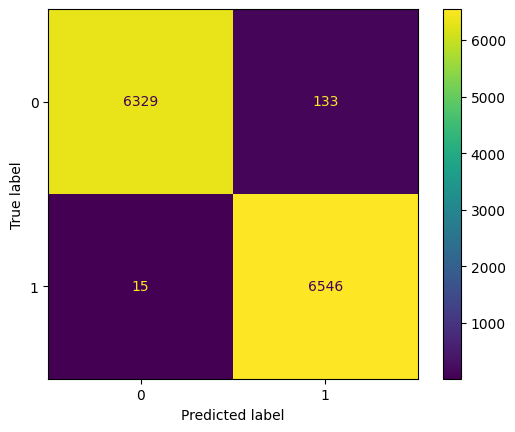


Training Dataset: Full  Test Basis: Wavefake
Accuracy: 0.9886354910542886
F1-score: 0.9888217522658611
Precision: 0.9800868393472076
Recall: 0.9977137631458619


In [66]:
plotConfusionMatrix(testWave['Pred_category'], testWave['category'])
results("Full", "Wavefake",testWave["Pred_category"], testWave["category"])

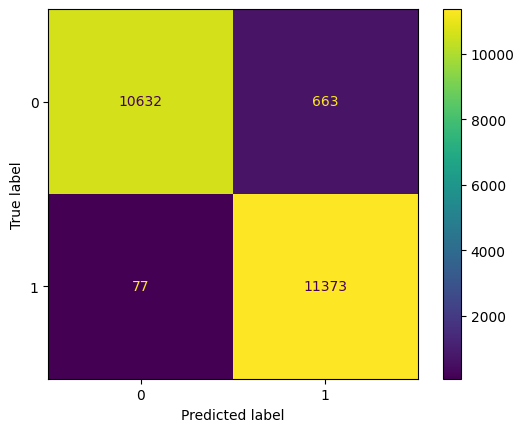


Training Dataset: Full  Test Basis: Full
Accuracy: 0.9674653770059354
F1-score: 0.9684918674955293
Precision: 0.9449152542372882
Recall: 0.9932751091703057


In [69]:
plotConfusionMatrix(pd.concat([testWave["Pred_category"],
                               testASV["Pred_category"],
                               testFoR["Pred_category"]]),
                    pd.concat([testWave["category"],
                               testASV["category"],
                               testFoR["category"]]))
results("Full", "Full",
        pd.concat([testWave["Pred_category"], testASV["Pred_category"], testFoR["Pred_category"]]),
        pd.concat([testWave["category"], testASV["category"], testFoR["category"]]))

In [70]:
# Tempo total de processamento
print("--- %s seconds ---" % (time.time() - start_time))

--- 50264.61330628395 seconds ---


In [71]:
print("--- %s hours ---" % ((time.time() - start_time)/3600))

--- 13.962395554979642 hours ---
